# Bagging
Part 2 of the course project in *Artificial intelligence applied to engineering* at ETSEIB, UPC, spring 2024. The team members contributing to the deliverable is 
- Lise Jakobsen
- Julie Sørlie Lund
- Magnus Ingnes Sagmo

The dataset used in this deliverable can be retrieved from [Kaggle](https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset).

## Data set review

#### Target class
The target class, `HeartDisease`, is a boolean class telling whether the patient has a heart disease. Subsequently, this is a classification problem.

#### Features
The data set has 11 features. Two of these, `ChestPainType` and `RestingECG`, are one-hot encoded. 

#### Preprocessing method
Before applying KNN
- zero values of `Cholesterol` are imputed using `sklearn.impute.KNNImputer`.
- the data is split into train and test set using `sklearn.model_selection.train_test_split`.
- the data is normalized using `sklearn.preprocessing.StandardScaler`.

In addition, we will try to both keep and remove outliers to see what produces best predictions. 

## Performance metrics

#### Recall
In the case of detecting heart diseases it is crucial to minimize the number of false negatives (people with a heart disease going unnoticed). We will therefore focus on minimizing recall.

#### F1-score
By solely focusing on recall, we can end with a too high number of false positives (by choosing a model that classifies everything as heart disease). We will therefore also look at the F1-score, as it offers a balance between precision and recall. 

#### Precision-recall curve
The precision-recall curve is a good way to visualize how well the model balances precision and recall. 

#### Confusion matrix
A good way to look at the number of false positives is looking at the confusion matrix. This will allow us to simultaneously look at false negatives, true positives and true negatives. 


## Hyperparameters

#### Number of estimators
The `n-estimators` is the number of base estimators in the ensemble. Increasing the number of estimators generally improves performance but also increases computational cost.

#### Maximum samples
The `max_samples` determines the number of samples to draw from the dataset to train each base estimator. Adjusting this can help in controlling overfitting and underfitting.

#### Maximum features
The `max_features` controls the number of features to draw from the dataset for each base estimator. Like max_samples, tuning this parameter can help in managing overfitting and underfitting.

#### Boostrap
The `bootstrap` parameter controls whether sampling is done with replacement. It impacts the diversity of the base estimators. Using bootstrap sampling (with replacement) typically helps in reducing variance, whereas not using it (without replacement) can sometimes improve performance depending on the dataset.

### Load data

We will split the data in training and test set, and only use the train data for the cross validation in the grid search. This will reduce the amount of data used to train the models and tuning hyperparameters, butt will ensure no data leakage and help reduce overfitting of the model. 

In [2]:
%load_ext autoreload
%autoreload 2

from preprocessor import Preprocessor
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, f1_score, precision_recall_curve, auc, precision_score
import numpy as np
import pandas as pd
from sklearn.model_selection import validation_curve

In [3]:
prep = Preprocessor()

X_train, X_test, y_train, y_test = prep.get_data(test_size=0.25, impute_method='knn', remove_outliers=True, scaling_method='standard')

### Set up hyperparameters grid

We will explore
- `n_estimators`: numbers [10, 50, 100 and 200]
- `max_samples`: numbers [0.5, 0.7, 1.0]
- `max_features`: numbers [0.5, 0.7, 1.0] 
- `bootstrap`: Bagging/sampling with replacement (True) or Pasting/sampling without replacement (False).

In [4]:
# Define the parameter grid
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0],
    'bootstrap': [True, False]
}

### Perform grid search

As stated above, we will focus mainly on recall and F1-score for our model evaluation. For the grid search we will use F1-score as evaluation metric, because
- using recall can cause an unacceptably poor precision.
- F1-score also considers true positives.

To narrow the number of combinations we will further evaluate, we retrieve the six best combinations from the grid search.

In [5]:
# Define model
bagging = BaggingClassifier(random_state=2)

# Perform grid search
grid_search = GridSearchCV(bagging, param_grid, cv=5, scoring='f1', return_train_score=True)
grid_search.fit(X_train, y_train)

# Extract the six best iterations, based on mean F1 score
results = pd.DataFrame(grid_search.cv_results_)
top_6 = results.nlargest(6, 'mean_test_score')  
# Extract only the interesting columns from the DataFrame
# Adjust the column names based on the parameters used in the grid search
top_6 = top_6[['param_n_estimators', 'param_max_samples', 'param_max_features', 'param_bootstrap', 'mean_test_score', 'std_test_score']]

top_6

,param_n_estimators,param_max_samples,param_max_features,param_bootstrap,mean_test_score,std_test_score
6,100,0.7,0.5,True,0.876170,0.019892
7,200,0.7,0.5,True,0.875399,0.024151
13,50,0.5,0.7,True,0.875163,0.043593
2,100,0.5,0.5,True,0.874668,0.024663
3,200,0.5,0.5,True,0.873346,0.026337
42,100,0.7,0.5,False,0.872441,0.025138


The six best combinations using F1-score are:

* `n_estimators` values of 50, 100, and 200.
* `max_samples` values of 0.5 and 0.7.
* `max_features` values of 0.5 and 0.7.
* `bootstrap`=True for five combinations and `bootstrap`=False for one combination.

The combination of hyperparameters with the highest mean F1 score from the grid search uses n_estimators=100, max_samples=0.7, max_features=0.5, and bootstrap=True. This combination achieves a mean test score of 0.876170 and a standard deviation of 0.019892. Having n_estimators at 100 provides a good balance between performance and stability, avoiding the issues of overfitting or increased variability seen with higher or lower values. This combination also has a relatively low standard deviation, showing stable performance across different folds.

### Evaluating top 6 combinations
We will continue by examining how these six top results perform on unseen data. We will look at 
- F1-score
- Recall
- Precision
- Precision-Recall Area Under Curve

In [6]:
# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    # Make prediction
    y_pred = model.predict(X_test)

    # Retrieve scores
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
    pr_auc = auc(recall_curve, precision_curve)

    return recall, f1, precision, pr_auc

In [7]:
# DataFrame with evaluation metric for each of the top 6 models
evaluation_results = pd.DataFrame(columns=['param_n_estimators', 'param_max_samples', 'param_max_features', 'param_bootstrap', 'Recall', 'Precision', 'F1-score', 'Precision-recall AUC'])

# Iterate the top 6 parameter combinations
for (index, row) in top_6.iterrows():

    # Dict with params from the row
    params = {
        'n_estimators': row['param_n_estimators'],
        'max_samples': row['param_max_samples'],
        'max_features': row['param_max_features'],
        'bootstrap': row['param_bootstrap']
    }

    # Fit the model with params
    model = BaggingClassifier(n_estimators=params['n_estimators'], max_samples=params['max_samples'], max_features=params['max_features'], bootstrap=params['bootstrap'], random_state=1)
    model.fit(X_train, y_train)
    
    # Evaluate the model
    recall, f1, precision, pr_auc = evaluate_model(model, X_test, y_test)

    new_row = {
        'param_n_estimators': params['n_estimators'],
        'param_max_samples': params['max_samples'],
        'param_max_features': params['max_features'],
        'param_bootstrap': params['bootstrap'],
        'Recall': round(recall, 3), 
        'Precision': round(precision, 3), 
        'F1-score': round(f1, 3), 
        'Precision-recall AUC': round(pr_auc, 3)
    }
    evaluation_results.loc[len(evaluation_results)] = new_row

evaluation_results = evaluation_results.sort_values(by=['Recall', 'F1-score'])
evaluation_results

,param_n_estimators,param_max_samples,param_max_features,param_bootstrap,Recall,Precision,F1-score,Precision-recall AUC
5,100,0.7,0.5,False,0.835,0.895,0.864,0.935
0,100,0.7,0.5,True,0.835,0.910,0.871,0.939
2,50,0.5,0.7,True,0.842,0.926,0.882,0.943
1,200,0.7,0.5,True,0.865,0.906,0.885,0.942
3,100,0.5,0.5,True,0.865,0.913,0.888,0.935
4,200,0.5,0.5,True,0.872,0.913,0.892,0.937


The combination of hyperparameters with the highest F1-score from the grid search uses `n_estimators`=200, `max_samples`=0.5, `max_features`=0.5, and `bootstrap`=True. This combination achieves a recall of 0.872, a precision of 0.913, an F1-score of 0.892, and a precision-recall AUC of 0.937. This provides a balanced model that captures enough variance while maintaining stability. This combination also achieves the highest F1-score, showing the best trade-off between precision and recall across different folds.

### Bias and variance

Next, we examine the model performance in the context of bias and variance by plotting a validation curve for each hyperparameter with different ranges.

In [8]:
def plot_validation_curve(param_name, param_range):
    # Calculate scores for validation curve
    train_scores, test_scores = validation_curve(
        BaggingClassifier(random_state=3),
        X_train, y_train, param_name=param_name, 
        param_range=param_range,
        cv=5, scoring="recall", n_jobs=-1)

    # Calculate mean and standard deviation for train and test scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot the validation curve
    plt.figure(figsize=(6, 3))
    plt.plot(param_range, train_mean, label="Training score", color="r")
    plt.plot(param_range, test_mean, label="Cross-validation score", color="g")

    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="r", alpha=0.1)
    plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="g", alpha=0.1)

    plt.title("Validation Curve for Bagging, recall")
    plt.xlabel(f"{param_name}")
    plt.ylabel("Recall")
    plt.legend(loc="best")
    plt.show()

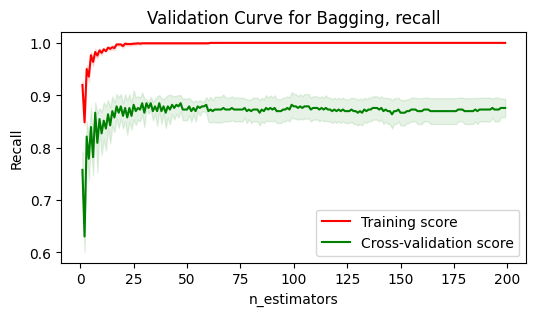

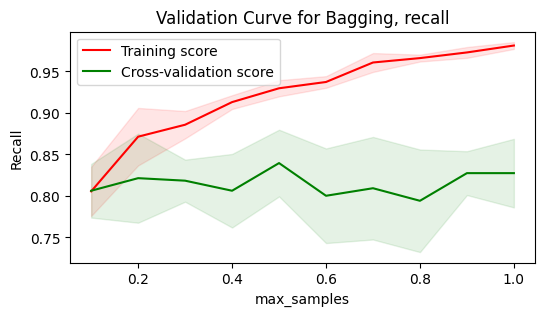

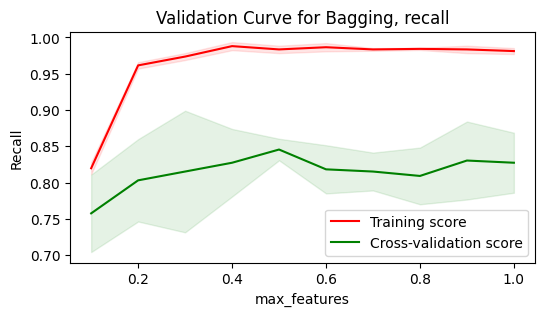

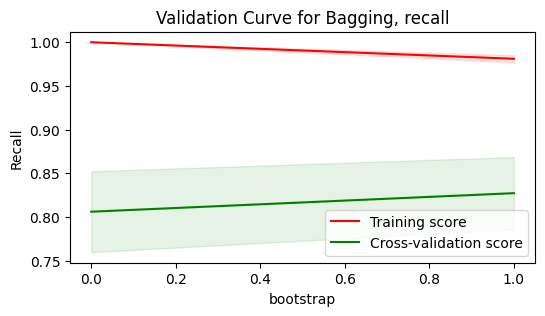

In [9]:
estimators_range = np.arange(1, 200)
plot_validation_curve('n_estimators', estimators_range)

samples_range = np.arange(0.1, 1.1, 0.1)  
plot_validation_curve('max_samples', samples_range)

features_range = np.arange(0.1, 1.1, 0.1)  
plot_validation_curve('max_features', features_range)

bootstrap_range = [True, False]
plot_validation_curve('bootstrap', bootstrap_range)

#### n_estimators
* The rapid increase in recall for both training and cross-validation data as n_estimators grows from 1 to 25 indicates that the model initially benefits greatly from additional estimators, which helps reduce bias.
* The plateau observed beyond n_estimators=25 shows that the model has reached a good balance between bias and variance, and further increasing n_estimators does not enhance performance, suggesting that the model is neither underfitting nor overfitting at this point.
* This analysis indicates that an optimal choice for n_estimators is around 25, where the model achieves a good balance between fitting the training data and generalizing to unseen data. So it shows that it choosing a number 25 is better then number 200 as first thought as it reduces overfitting.

#### max_samples
* The training data increasing to 100% as max_samples approaches 1 indicates that the model can perfectly learn the training data with more samples, but this does not necessarily translate to better generalization.
* The cross-validation recall line remaining stable with a small peak at max_samples=0.5 suggests that the model generalizes best when each base estimator is trained on 50% of the data. This balance helps avoid overfitting while still capturing significant patterns in the data.
* This analysis indicates that an optimal choice for max_samples is around 0.5 as anticipated, where the model achieves a balance between fitting the training data and generalizing to unseen data, reflected by the small peak in the cross-validation recall.

#### max_features
* The training data increasing to 0.95 as max_features approaches 0.2 indicates that including more features during training greatly improves the model's ability to learn the training data, resulting in higher recall scores.
* The cross-validation recall line slowly increasing from 0.75 to 0.82 as max_features goes from 0 to 0.5 suggests that including more features during training has a modest positive effect on the model's ability to generalize to unseen data. However, beyond a certain point (max_features=0.5), further increasing the number of features does not significantly improve performance.
* This analysis suggests that an optimal choice for max_features is around 0.5 as anticipated, where the model achieves a balance between capturing enough information from the data to learn effectively and avoiding overfitting by not including too many features.

#### bootstrap
* The decrease in training recall and the increase in cross-validation recall as bootstrap changes from False to True suggest that enabling bootstrapping helps improve the model's generalization ability by reducing overfitting.
* The fact that the training recall remains relatively high even when bootstrapping is enabled indicates that the model still learns the training data well, but with less overfitting compared to when bootstrapping is disabled.
* So, enabling bootstrapping (bootstrap=True) appears to improve the model's performance by reducing overfitting and enhancing its ability to generalize to unseen data. This is what we inicially anticipated.


#### Overall Conclusion
Choosing an appropriate number of estimators, such as around 25, helps strike a balance between bias and variance, reducing overfitting while maintaining good generalization. Similarly, selecting optimal values for max_samples and max_features, around 0.5, ensures the model captures important patterns in the data without including too much noise. Enabling bootstrapping proves beneficial, enhancing the model's ability to generalize by reducing overfitting.